In [145]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad
from tqdm import tqdm
import scipy.integrate as spi
import matplotlib.pyplot as plt
import scipy
import itertools

In [49]:
# A is N-cycle and b is 0
def gen_energy_params(N):
    A = np.zeros((N, N))
    indices = np.arange(0, N, 1)
    targets = np.roll(indices, -1)
    A[indices,targets] = 1
    A = A + A.T
    A = jnp.array(A)
    b = jnp.zeros(N)
    return A, b

# U(x) = -beta(x.T A x + b.T x)
def gen_energy_func(A, b, beta):
    def U(x):
        return -beta * (0.5 * jnp.dot(x, jnp.matvec(A, x)) + jnp.dot(b, x))
    return U

In [3]:
from itertools import product

def calc_baseline_distribution(calc_U, N):
    sample_space = jnp.array(list(product([-1, 1], repeat=N)))
    U_vals = calc_U(sample_space)
    exp_U_vals = jnp.exp(-U_vals)
    distr = exp_U_vals / jnp.sum(exp_U_vals)
    distr_map = {}
    for i, sample in enumerate(sample_space):
        distr_map[tuple(sample.tolist())] = distr[i]
    return distr_map
    
def calc_variational_dist(samples, baseline_distr):
    assert all([tuple(k.tolist()) in baseline_distr for k in samples])
    num_samples = len(samples)
    distr_map = {k : 0.0 for k in baseline_distr}
    for sample in samples:
        key = tuple(sample.tolist())
        distr_map[key] += 1 / num_samples
    vd = sum([abs(distr_map[k]-baseline_distr[k]) for k in baseline_distr]) / 2
    return vd, distr_map

In [4]:
def sample_MuCOLA(calc_dU, proj_x, x0, iter, alpha, return_vd_traj=False, baseline_distr=None):
    assert not return_vd_traj or baseline_distr is not None, "To get vd traj, you must pass in the baseline distribution map"

    m, N = x0.shape

    half_alpha = 0.5 * alpha
    sqrt_alpha = np.sqrt(alpha)

    zero_mean = np.zeros(N)
    id_cov = np.identity(N)

    x_curr = x0

    vd_traj = []
    if return_vd_traj:
        vd, _ = calc_variational_dist(x_curr, baseline_distr)
        vd_traj.append(vd)

    for _ in tqdm(range(iter)):
        z = np.random.multivariate_normal(zero_mean, id_cov, size=(m, ))
        x_embed = x_curr - half_alpha * calc_dU(x_curr) + sqrt_alpha * z
        x_curr = proj_x(x_embed)
        
        if return_vd_traj:
            vd, _ = calc_variational_dist(np.array(x_curr), baseline_distr)
            vd_traj.append(vd)

    if return_vd_traj:
        return x_curr, vd_traj
    return x_curr

In [5]:
def proj_x(x):
    x = np.sign(x)
    x[x==0] = 1
    return jnp.array(x)

In [78]:
m = 10000
iter = 25
N = 8
beta = 0.42
A, b = gen_energy_params(N)
U_func = gen_energy_func(A, b, beta)
calc_U = jax.jit(jax.vmap(U_func))
calc_dU = jax.jit(jax.vmap(jax.grad(U_func)))

baseline_distr = calc_baseline_distribution(calc_U, N)

100%|██████████| 25/25 [00:01<00:00, 15.73it/s]


0.16134833


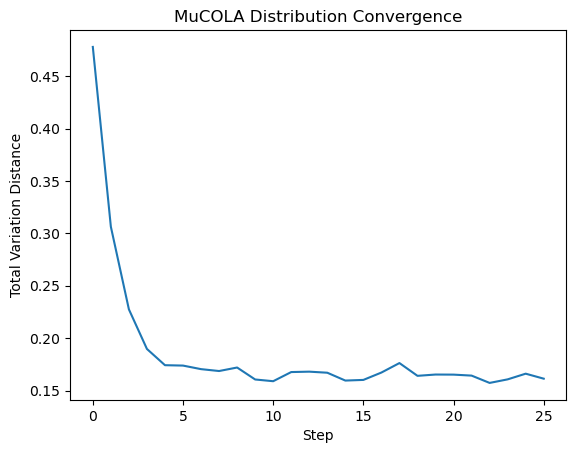

In [79]:
alpha = 1.5
x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding
x0 = jnp.array(x0)

samples, vd_traj = sample_MuCOLA(calc_dU, proj_x, x0, iter, alpha, return_vd_traj=True, baseline_distr=baseline_distr)
vd, distr_map = calc_variational_dist(samples, baseline_distr)
print(vd)

plt.plot(vd_traj)
plt.title("MuCOLA Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.show()

In [80]:
def sample_MH(calc_U, x0, iter, return_vd_traj=False, baseline_distr=None):
    assert not return_vd_traj or baseline_distr is not None, "To get vd traj, you must pass in the baseline distribution map"

    m, N = x0.shape
    x_curr = jnp.array(x0)

    U_curr = calc_U(x_curr)

    vd_traj = []
    if return_vd_traj:
        vd, _ = calc_variational_dist(x_curr, baseline_distr)
        vd_traj.append(vd)

    for _ in tqdm(range(iter)):
        x_prop = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32)
        U_prop = calc_U(x_prop)

        log_accept_ratio = -(U_prop - U_curr)
        accept = np.log(np.random.uniform(size=(m,))) < log_accept_ratio

        accept = accept[:, None]
        x_curr = np.where(accept, x_prop, x_curr)
        U_curr = np.where(accept.squeeze(), U_prop, U_curr)

        if return_vd_traj:
            vd, _ = calc_variational_dist(x_curr, baseline_distr)
            vd_traj.append(vd)

    if return_vd_traj:
        return x_curr, vd_traj
    return x_curr


100%|██████████| 25/25 [00:01<00:00, 24.04it/s]


0.0567905


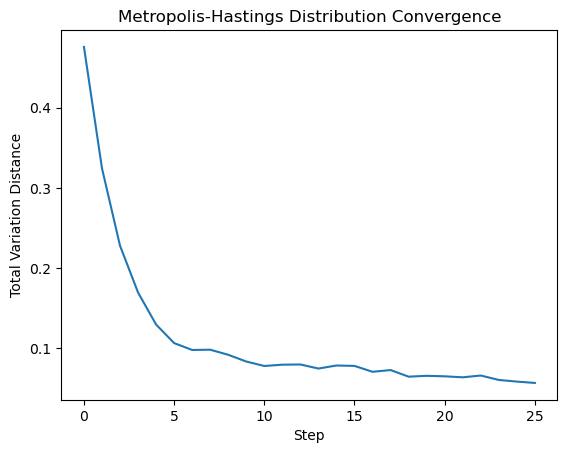

In [81]:
x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding
x0 = jnp.array(x0)

samples_mh, vd_traj_mh = sample_MH(calc_U, x0, iter, return_vd_traj=True, baseline_distr=baseline_distr)
vd_mh, distr_map_mh = calc_variational_dist(samples_mh, baseline_distr)
print(vd_mh)

plt.plot(vd_traj_mh)
plt.title("Metropolis-Hastings Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.show()

In [82]:
def sample_pNCG(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=False, baseline_distr=None):
    assert not return_vd_traj or baseline_distr is not None, "To get vd traj, you must pass in the baseline distribution map"

    m, N = x0.shape # THIS ASSUMES EMBEDDING DIM = 1

    half_inv_alpha = 1 / (2 * alpha)

    x_curr = jnp.array(x0)

    vd_traj = []
    
    if return_vd_traj:
        vd, _ = calc_variational_dist(x_curr, baseline_distr)
        vd_traj.append(vd)

    vocab_array = jnp.stack(vocab)  # shape (vocab_size, embedding_dim)

    key = jax.random.PRNGKey(0)

    def calc_stats(x):
        U = calc_U(x)
        dU = calc_dU(x)
        diffs = vocab_array[None, None, :, :] - x[:, :, None, None]
        p_norms_p = jnp.linalg.norm(diffs, ord=p, axis=-1) ** p
        grad_prod = jnp.einsum("abcd,abd->abc", diffs, dU[:, :, None])
        logits = -0.5 * grad_prod - half_inv_alpha * p_norms_p
        probs = jax.nn.softmax(logits, axis=-1)
        
        return U, dU, logits, probs
    
    def calc_prob_gen(indices, probs):
        prop_probs = probs[jnp.arange(m)[:, None], jnp.arange(N), indices]
        total_prob = jnp.prod(prop_probs, axis=-1)
        return total_prob

    curr_U, curr_dU, curr_logits, curr_probs = calc_stats(x_curr)
    curr_indices = ((x0 + 1).squeeze() // 2).astype(int) # [-1, 1] => [0, 1]

    for _ in tqdm(range(iter)):
        flat_logits = curr_logits.reshape(-1, curr_logits.shape[-1])

        key, subkeys_key = jax.random.split(key)
        subkeys = jax.random.split(subkeys_key, m * N)
        samples_flat = jax.vmap(
            lambda k, l: jax.random.categorical(k, l)
        )(subkeys, flat_logits)

        samples = samples_flat.reshape(m, N) 
        x_prop = np.array(vocab)[samples].squeeze()

        prop_U, prop_dU, prop_logits, prop_probs = calc_stats(x_prop)
        
        gen_prob = calc_prob_gen(samples, curr_probs)
        rev_gen_prob = calc_prob_gen(curr_indices, prop_probs)

        key, subkey = jax.random.split(key)
        accept_prob = jnp.exp(curr_U - prop_U) * rev_gen_prob / gen_prob
        accept = (accept_prob > jax.random.uniform(subkey, shape=(m,))).astype(int)
        x_curr = np.where(accept[:, None], x_prop, x_curr) # type: ignore
        curr_U = np.where(accept, prop_U, curr_U) # type: ignore
        curr_dU = np.where(accept[:, None], prop_dU, curr_dU) # type: ignore
        curr_logits = np.where(accept[:, None, None], prop_logits, curr_logits) # type: ignore
        curr_probs = np.where(accept[:, None, None], prop_probs, curr_probs) # type: ignore
        curr_indices = np.where(accept[:, None], samples, curr_indices) # type: ignore

        if return_vd_traj:
            vd, _ = calc_variational_dist(x_curr, baseline_distr)
            vd_traj.append(vd)

    if return_vd_traj:
        return x_curr, vd_traj
    return x_curr

x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding
x0 = jnp.array(x0)

alpha = 1.0
vocab = [np.array([-1.0]), np.array([1.0])]
samples_ncg, vd_traj_ncg = sample_pNCG(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=True, baseline_distr=baseline_distr)
vd_ncg, distr_map_ncg = calc_variational_dist(samples_ncg, baseline_distr)
print(vd_ncg)

100%|██████████| 25/25 [00:03<00:00,  7.48it/s]

0.051568218


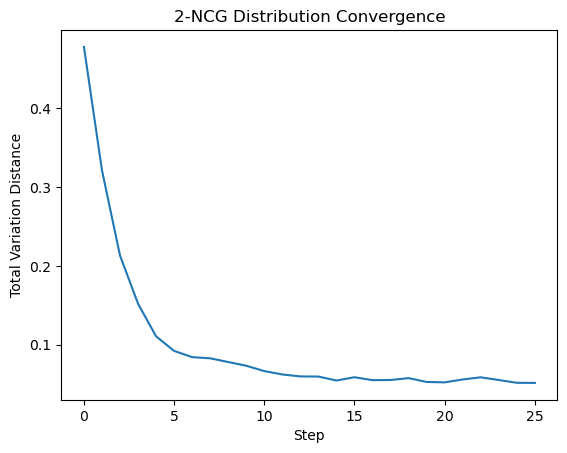

In [83]:
plt.plot(vd_traj_ncg)
plt.title("2-NCG Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.show()

In [84]:
def sample_gwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=False, baseline_distr=None, edit_pos_method='uniform', temp=1e-2, eps=1e-9):
    assert not return_vd_traj or baseline_distr is not None, "To get vd traj, you must pass in the baseline distribution map"
    assert edit_pos_method in ['uniform', 'saliency']

    def calc_batch_probs(x):
        if edit_pos_method == 'uniform':
            batched_probs = None
        elif edit_pos_method == 'saliency':
            dU = calc_dU(x)
            saliency = np.maximum(np.abs(dU) ** (1 / temp), eps)
            Z = np.sum(saliency, axis=-1)
            batched_probs = saliency / Z[:, None]
        else:
            raise ValueError(f"Invalid edit position method: {edit_pos_method}")
        return batched_probs
    
    def calc_prob_gen(targets, select_probs):
        target_probs = select_probs[np.arange(m), targets]
        return target_probs

    m, N = x0.shape

    x_curr = x0.copy()
    
    vd_traj = []
    
    if return_vd_traj:
        vd, _ = calc_variational_dist(x_curr, baseline_distr)
        vd_traj.append(vd)

    key = jax.random.PRNGKey(0)

    curr_U = calc_U(x_curr)
    curr_batched_probs = calc_batch_probs(x_curr)

    for _ in tqdm(range(iter)):
        key, subkey = jax.random.split(key)
        subkey1, subkey2 = jax.random.split(subkey, 2)
        
        subkeys = jax.random.split(subkey1, m)
        flip_targets = jax.vmap(
            lambda k, probs: jax.random.choice(k, N, p=probs)
        )(subkeys, curr_batched_probs)


        x_prop = x_curr.copy()
        x_prop[np.arange(0, m, 1), flip_targets] *= -1

        prop_U = calc_U(x_prop)
        prop_batched_probs = calc_batch_probs(x_prop)
        
        if edit_pos_method != 'uniform':
            gen_prob = calc_prob_gen(flip_targets, curr_batched_probs)
            rev_gen_prob = calc_prob_gen(flip_targets, prop_batched_probs)
        else:
            gen_prob, rev_gen_prob = 1, 1

        accept_prob = np.exp(curr_U - prop_U) * rev_gen_prob / gen_prob
        accept = np.array((accept_prob > jax.random.uniform(subkey2, shape=(m,)))).astype(int)
        x_curr = np.where(accept[:, None], x_prop, x_curr) # type: ignore
        curr_U = np.where(accept, prop_U, curr_U) # type: ignore
        
        if edit_pos_method != 'uniform':
            curr_batched_probs = np.where(accept[:, None], prop_batched_probs, curr_batched_probs) # type: ignore

        if return_vd_traj:
            vd, _ = calc_variational_dist(x_curr, baseline_distr)
            vd_traj.append(vd)

    if return_vd_traj:
        return x_curr, vd_traj
    return x_curr

x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:01<00:00, 12.59it/s]


0.07031421


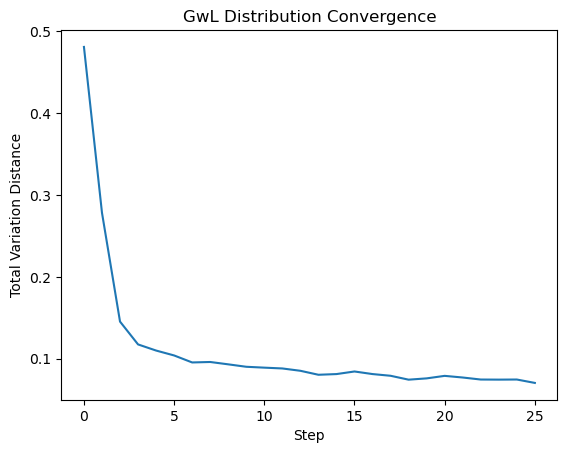

In [85]:
alpha = 1.0
vocab = [np.array([-1.0]), np.array([1.0])]
temp = 1e-2
eps = 1e-9
edit_method = 'saliency'
samples_gwl, vd_traj_gwl = sample_gwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=True, baseline_distr=baseline_distr, edit_pos_method=edit_method, temp=temp, eps=eps)
vd_gwl, distr_map_gwl = calc_variational_dist(samples_gwl, baseline_distr)
print(vd_gwl)

plt.plot(vd_traj_gwl)
plt.title("GwL Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.show()

100%|██████████| 25/25 [00:01<00:00, 15.10it/s]


0.07031421


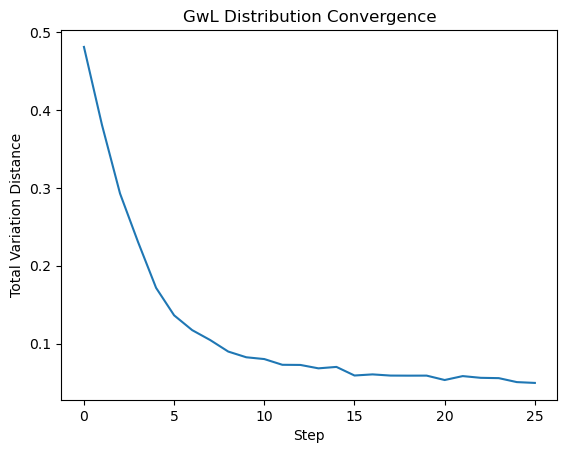

In [86]:
alpha = 1.0
vocab = [np.array([-1.0]), np.array([1.0])]
edit_method = 'uniform'
samples_ugwl, vd_traj_ugwl = sample_gwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=True, baseline_distr=baseline_distr, edit_pos_method=edit_method, temp=temp, eps=eps)
vd_ugwl, distr_map_ugwl = calc_variational_dist(samples_gwl, baseline_distr)
print(vd_ugwl)

plt.plot(vd_traj_ugwl)
plt.title("GwL Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.show()

In [235]:
# 2-Gibbs-With-Langevin
def sample_2gwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=False, baseline_distr=None, order=2, edit_pos_method='uniform', temp=1e-2, eps=1e-9):
    assert not return_vd_traj or baseline_distr is not None, "To get vd traj, you must pass in the baseline distribution map"
    assert edit_pos_method in ['uniform', 'saliency', 'interaction']

    m, N = x0.shape
    
    x_curr = x0.copy()
    vocab_array = np.stack(vocab) # shape (vocab_size, embedding_dim)

    inv_alpha = 1 / alpha 

    def calc_stats(x):
        U = calc_U(x)
        dU = np.array(calc_dU(x))
        diffs = vocab_array[None, None, :, :] - x[:, :, None, None]
        p_norms_p = np.linalg.norm(diffs, ord=p, axis=-1) ** p
        grad_prod = np.einsum("abcd,abd->abc", diffs, dU[:, :, None])
        logits = -grad_prod - inv_alpha * p_norms_p

        if edit_pos_method == 'uniform':
            batched_probs = np.full_like(dU, 1 / N)
        elif edit_pos_method == 'saliency':
            saliency = np.maximum(np.abs(dU) ** (1 / temp), eps)
            Z = np.sum(saliency, axis=-1)
            batched_probs = saliency / Z[:, None]
        elif edit_pos_method == 'interaction':
            # V(i, j) = E[-U(x\{i, j})]
            pair_prods = np.tril(x[:, :, None] * x[:, None, :], k=-1)

            total_sum = pair_prods.sum(axis=(1, 2))
            row_sum = pair_prods.sum(axis=2)
            col_sum = pair_prods.sum(axis=1)

            masked_sums = (
                total_sum[:, None, None]
                - row_sum[:, :, None]
                - col_sum[:, None, :]
                + pair_prods
            )
            mask_values = np.full_like(pair_prods, -np.inf)

            # Fill only i < j entries
            i, j = np.triu_indices(N, k=1)
            mask_values[:, i, j] = beta * masked_sums[:, i, j]

            flattened_values = mask_values.reshape(m, -1) / temp
            batched_probs = scipy.special.softmax(flattened_values, axis=-1)
        else:
            raise ValueError(f"Invalid edit position method: {edit_pos_method}")

        return U, dU, logits, batched_probs

    def calc_2d_logits(logits, indices, targets):
        target_logits = logits[np.arange(m)[:, None], targets]
        A = target_logits[:, 0, :]
        B = target_logits[:, 1, :]
        C = A[:, :, None] + B[:, None, :]
        target_indices = indices[np.arange(m)[:, None], targets]
        C[np.arange(m), target_indices[:, 0], target_indices[:, 1]] = -np.inf # Makes the probability of a self loop be 0.
        return C

    def calc_select_probs(select_probs, targets):
        if edit_pos_method == "interaction":
            ravel_probs = select_probs.reshape(-1, N, N)
            row_targets = targets[:, 0]
            col_targets = targets[:, 1]
            target_probs = ravel_probs[np.arange(m), row_targets, col_targets]
            return target_probs
        else:
            p1 = select_probs[np.arange(m), targets[:, 0]]
            p2 = select_probs[np.arange(m), targets[:, 1]]
            denom = 1.0 - p1
            return p1 * (p2 / denom)

    def calc_prob_gen(indices, targets, logits, select_probs):
        a1_indices = indices[np.arange(m), targets[:, 0]]
        a2_indices = indices[np.arange(m), targets[:, 1]]

        probs = scipy.special.softmax(logits, axis=-1)
        a_ravel = np.ravel_multi_index((a1_indices, a2_indices), (order, targets.shape[-1]))
        prop_probs = probs[np.arange(m), a_ravel]

        target_probs = calc_select_probs(select_probs, targets)
        total_probs = prop_probs * target_probs

        total_probs = prop_probs * target_probs
        return total_probs
    
    def select_edit_positions(subkey, batched_probs, edits):
        subkeys = jax.random.split(subkey, m)
        flip_targets = np.array(jax.vmap(
            lambda k, probs: jax.random.choice(
                k,
                batched_probs.shape[-1],
                shape=(edits,),
                replace=False,
                p=probs 
            )
        )(subkeys, batched_probs))
        
        return flip_targets # (m, order)

    vd_traj = []
    
    if return_vd_traj:
        vd, _ = calc_variational_dist(x_curr, baseline_distr)
        vd_traj.append(vd)

    key = jax.random.PRNGKey(0)

    curr_indices = ((x0 + 1).squeeze() // 2).astype(int) # [-1, 1] => [0, 1]
    curr_U, curr_dU, curr_logits, curr_select_probs = calc_stats(x_curr)

    for _ in tqdm(range(iter)):
        key, subkey = jax.random.split(key)
        if edit_pos_method == 'interaction':
            flat_2d_targets = select_edit_positions(subkey, curr_select_probs, 1) # We select pairs explicitly
            i_targets, j_targets = np.unravel_index(flat_2d_targets, (N, N))
            flip_targets = np.hstack((i_targets, j_targets))
        else:
            flip_targets = select_edit_positions(subkey, curr_select_probs, order)

        curr_2d_logits = calc_2d_logits(curr_logits, curr_indices, flip_targets)
        key, subkeys_key = jax.random.split(key)
        subkeys = jax.random.split(subkeys_key, m)
        flattened_2d_logits = curr_2d_logits.reshape((m, -1)) # (m, order * d)
        target_samples = np.array(jax.vmap(
            lambda k, l: jax.random.categorical(k, l)
        )(subkeys, flattened_2d_logits))
        target1_samples, target2_samples = np.unravel_index(target_samples, (m, curr_2d_logits.shape[1])) # (m, order)

        x_prop = np.array(x_curr)
        prop_indices = np.array(curr_indices)
        x_prop[np.arange(m), flip_targets[:, 0]] = np.array(vocab)[target1_samples].squeeze()
        x_prop[np.arange(m), flip_targets[:, 1]] = np.array(vocab)[target2_samples].squeeze()
        prop_indices[np.arange(m), flip_targets[:, 0]] = target1_samples
        prop_indices[np.arange(m), flip_targets[:, 1]] = target2_samples

        prop_U, prop_dU, prop_logits, prop_select_probs = calc_stats(x_prop)

        flattened_prop_2d_logits = calc_2d_logits(prop_logits, prop_indices, flip_targets).reshape((m, -1))
        gen_prob = calc_prob_gen(prop_indices, flip_targets, flattened_2d_logits, curr_select_probs)
        rev_gen_prob = calc_prob_gen(curr_indices, flip_targets, flattened_prop_2d_logits, prop_select_probs)

        key, subkey = jax.random.split(key)
        accept_prob = np.exp(curr_U - prop_U) * rev_gen_prob / gen_prob
        accept = np.array((accept_prob > jax.random.uniform(subkey, shape=(m,)))).astype(int)
        x_curr = np.where(accept[:, None], x_prop, x_curr)
        curr_U = np.where(accept, prop_U, curr_U)
        curr_dU = np.where(accept[:, None], prop_dU, curr_dU)
        curr_logits = np.where(accept[:, None, None], prop_logits, curr_logits)
        curr_indices = np.where(accept[:, None], prop_indices, curr_indices)
        curr_select_probs = np.where(accept[:, None], prop_select_probs, curr_select_probs)

        if return_vd_traj:
            vd, _ = calc_variational_dist(x_curr, baseline_distr)
            vd_traj.append(vd)

    if return_vd_traj:
        return x_curr, vd_traj
    return x_curr

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:02<00:00, 12.46it/s]


0.062122647


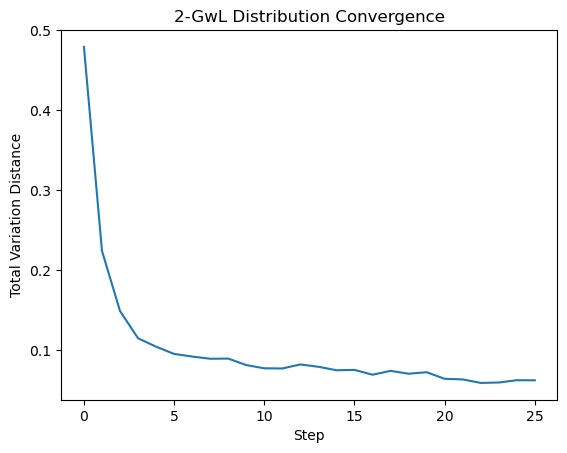

In [236]:
x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding

order = 2
alpha = 1.0
edit_method = 'saliency'
temp = 1e-2
eps = 1e-9
vocab = [np.array([-1.0]), np.array([1.0])]
samples_2gwl, vd_traj_2gwl = sample_2gwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=True, baseline_distr=baseline_distr, order=order, edit_pos_method=edit_method, temp=temp, eps=eps)
vd_2gwl, distr_map_2gwl = calc_variational_dist(samples_2gwl, baseline_distr)

print(vd_2gwl)
plt.plot(vd_traj_2gwl)
plt.title(f"{order}-GwL Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")
plt.xticks(np.arange(0, iter + 1, 5))

plt.show()

100%|██████████| 25/25 [00:02<00:00,  9.81it/s]

0.056425657


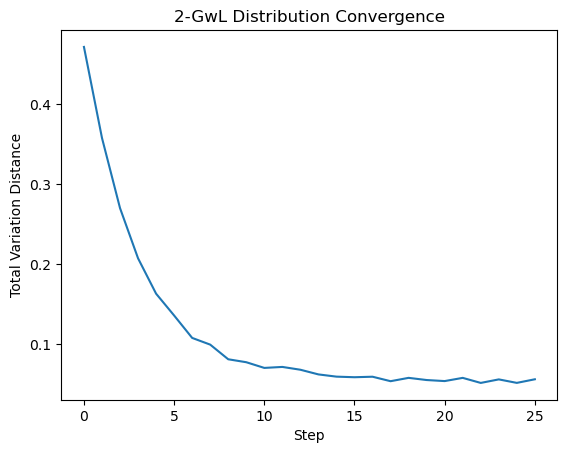

In [237]:
x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding

order = 2
alpha = 1.0
edit_method = 'interaction'
temp = 1.0
vocab = [np.array([-1.0]), np.array([1.0])]
samples_2igwl, vd_traj_2igwl = sample_2gwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=True, baseline_distr=baseline_distr, order=order, edit_pos_method=edit_method, temp=temp, eps=eps)
vd_2igwl, distr_map_2igwl = calc_variational_dist(samples_2igwl, baseline_distr)

print(vd_2igwl)
plt.plot(vd_traj_2igwl)
plt.title(f"{order}-GwL Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")
plt.xticks(np.arange(0, iter + 1, 5))

plt.show()

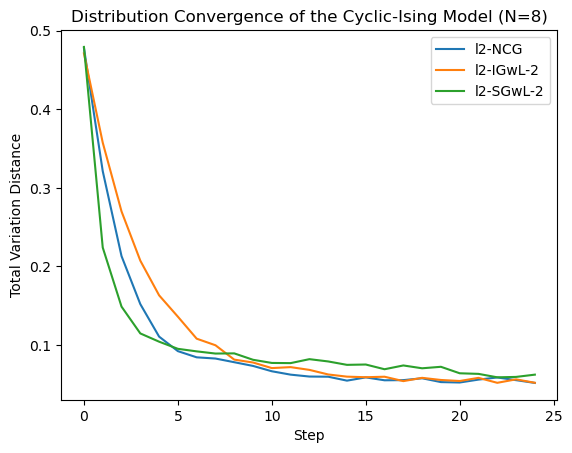

In [238]:
graph_n = 25

# plt.plot(vd_traj_mh[:graph_n], label='Metropolis-Hastings')
# plt.plot(vd_traj[:graph_n], label='MuCOLA')
plt.plot(vd_traj_ncg[:graph_n], label='l2-NCG')
# plt.plot(vd_traj_ugwl[:graph_n], label='l2-GwL-1')
# plt.plot(vd_traj_gwl[:graph_n], label='l2-SGwL-1')
plt.plot(vd_traj_2igwl[:graph_n], label='l2-IGwL-2')
plt.plot(vd_traj_2gwl[:graph_n], label='l2-SGwL-2')
plt.title(f"Distribution Convergence of the Cyclic-Ising Model (N={N})")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.legend()
plt.show()

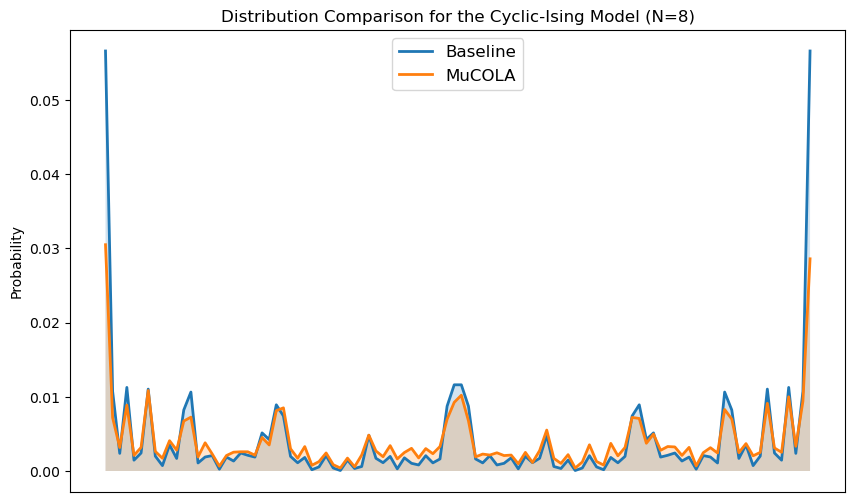

In [240]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.interpolate import make_interp_spline

# Example categorical distributions
x = np.arange(len(baseline_distr))
baseline_values = np.array(list(baseline_distr.values()))
sample_values = np.array(list(distr_map.values()))

# Create smooth x-axis for interpolation
x_smooth = np.linspace(x.min(), x.max(), 100)

# Interpolate baseline and sample distributions
baseline_smooth = make_interp_spline(x, baseline_values)(x_smooth)
sample_smooth = make_interp_spline(x, sample_values)(x_smooth)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=x_smooth, y=baseline_smooth, label='Baseline', linewidth=2)
sns.lineplot(x=x_smooth, y=sample_smooth, label='MuCOLA', linewidth=2)

plt.fill_between(x_smooth, baseline_smooth, alpha=0.2)
plt.fill_between(x_smooth, sample_smooth, alpha=0.2)

plt.xticks([])
plt.ylabel("Probability")
plt.title(f"Distribution Comparison for the Cyclic-Ising Model (N={N})")
plt.legend(fontsize=12)
plt.show()
